In [1]:
# Explore fingerprint data

In [2]:
# Sourcing
# Pre-processing
# Feature extraction
# Post-processing
# Matching

In [3]:
import os
import cv2
import sys
import math
import warnings
import numpy as np
from zipfile import ZipFile

import pandas as pd

#import gdal
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style()

from scipy import ndimage as ndi
from skimage import feature

from PIL import Image
from IPython.display import display

if not sys.warnoptions:
    warnings.simplefilter("ignore")

%matplotlib inline

In [4]:
# Load path to the libs folder. 
path_libs = '/Users/Orchestrator/Desktop/Toptal/Fingerprints/dragos-iliuta/src/'
sys.path.insert(0, path_libs)

In [5]:
from libs.enhancing import *
from libs.basics import *
from libs.processing import *

# Sourcing

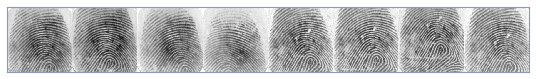

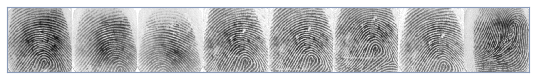

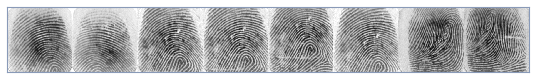

In [6]:
display_dataset('A', size=1.2, users=3)

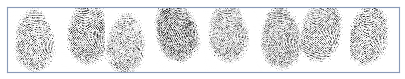

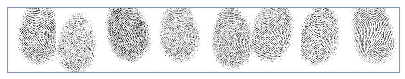

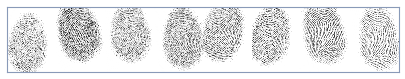

In [7]:
display_dataset('B', size=1.2, users=3)

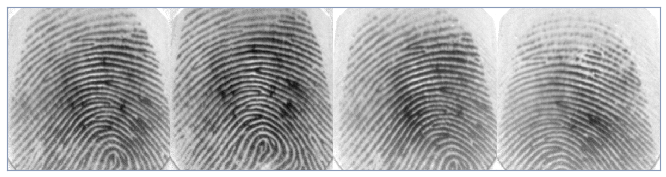

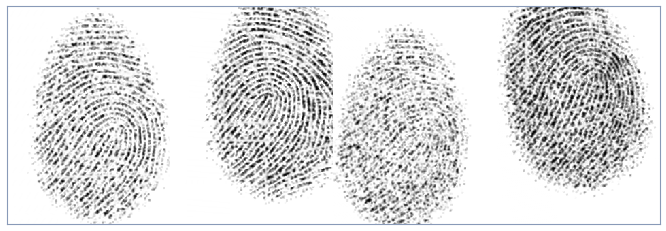

In [8]:
display_dataset('A', size=3, users=1, samples=4)
display_dataset('B', size=4, users=1, samples=4)

# Pre-processing

In [9]:
path = '../data/Fingerprints - Set A/105_4.tif'

In [10]:
img = cv2.imread(path, 0)
# DFT computation tends to be faster on arrays with sizes of a power of 2, or a multiple of 2, 3, 5 
# For using an optimal shape, padding might be required (0s)
print(f'Base image shape: {img.shape}')
print(f'Optiml image shape: {(cv2.getOptimalDFTSize(img.shape[0]), cv2.getOptimalDFTSize(img.shape[1]))}')

Base image shape: (300, 300)
Optiml image shape: (300, 300)


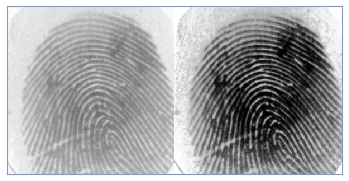

In [11]:
# Before and after equalisation.
# https://en.wikipedia.org/wiki/Histogram_equalization
img_eq = histogram_equalisation(img)
display_image(np.hstack((img, img_eq)))

# img_eq = cv.equalizeHist(img)
# display_image(np.hstack((img, img_eq)))

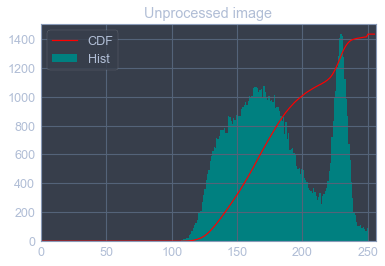

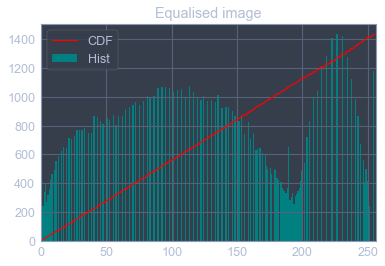

In [12]:
# Equalisation visualisation. 
color_range = 256

plt.plot(cdf_normalised(img, color_range), color = 'red')
plt.hist(img.flatten(), color_range, [0, color_range], color = 'teal')
plt.xlim([0, color_range])
plt.legend(('CDF','Hist'))
plt.title('Unprocessed image')
plt.show()

plt.plot(cdf_normalised(img_eq, color_range), color = 'red')
plt.hist(img_eq.flatten(), color_range, [0, color_range], color = 'teal')
plt.xlim([0, color_range])
plt.legend(('CDF','Hist'))
plt.title('Equalised image')
plt.show()

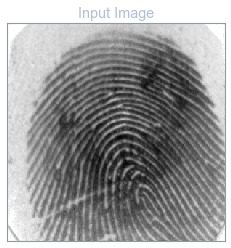

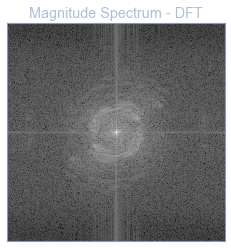

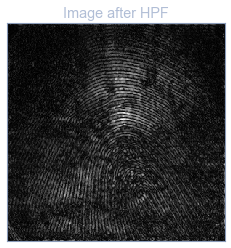

In [13]:
magnitude_spectrum = 20 * np.log(np.abs(fourier_transform(img)))
img_hpf = high_pass_filter(img)

display_image(img, 'Input Image')
display_image(magnitude_spectrum, 'Magnitude Spectrum - DFT')
display_image(img_hpf, 'Image after HPF')

# Feature extraction
We extract the fingerprint ridges by removing the background and thinning the ridges. We also extract ridge endings and bifurcations (minutiae).

In [14]:
from scipy import ndimage, signal

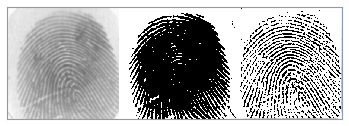

Threshold OTSU: 188.0


In [15]:
# Binarise image
# Direct application tends to obfuscate ridges. The details are much better handled by a 
# rolling window approach as presented in 'binarise' function.
img_bin = binarise(img)
img_blur = cv2.GaussianBlur(img, (5,5), 0)
threshold, img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

display_image(np.hstack((img_blur, img_otsu, img_bin)))
print(f'Threshold OTSU: {threshold}')

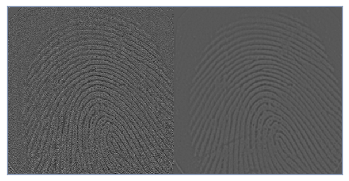

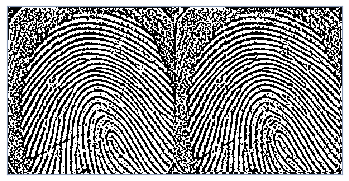

In [16]:
# Edge detection
img_laplace = cv2.Laplacian(img, cv2.CV_64F)
img_blur = cv2.GaussianBlur(img_laplace, (5,5), 0)
ret, img_bin = cv2.threshold(img_blur, 0, 255, 0)
img_bin_custom = binarise(img_blur)
    
display_image(np.hstack((img_laplace, img_blur)))
display_image(np.hstack((img_bin, img_bin_custom)))

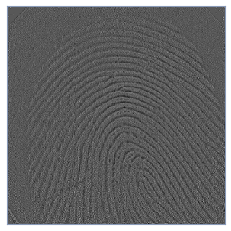

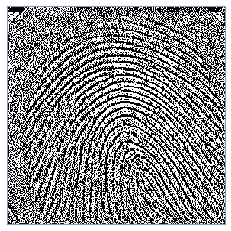

In [17]:
_, bin_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin_custom = binarise(img_laplace)

display_image(img_laplace)
display_image(img_bin_custom)

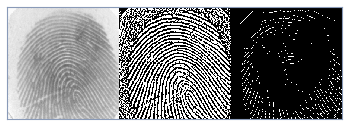

In [18]:
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)

ret, img_base = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
done = False

while not done:
    eroded = cv2.erode(img_base, element)
    temp = cv2.dilate(eroded, element)
    temp = cv2.subtract(img_base, temp)
    skel = cv2.bitwise_or(skel, temp)
    img_base = eroded.copy()

    zeros = size - cv2.countNonZero(img_base)
    if zeros == size:
        done = True
        
# Smoothing required after binarisation. 
display_image(np.hstack((img, img_bin, skel)))

In [19]:
path_root = f'../data/Fingerprints - Set A'
all_files = [f'{path_root}/{name}' for name in os.listdir(path_root)]

all_files[:2]

['../data/Fingerprints - Set A/102_6.tif',
 '../data/Fingerprints - Set A/106_2.tif']

In [20]:
raw_img = load_image(all_files[0], True)

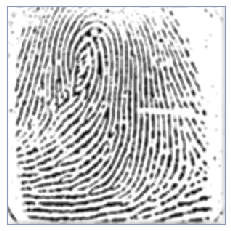

In [21]:
# Gabor filtering (binarise) - edge detection
def build_filters():
    filters = []
    ksize = 5
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), theta=theta, sigma=2.0, 
                                 lambd=15.0, gamma=0.25, psi=0, ktype=cv2.CV_64F)
        # ksize – Size of the filter returned.
        # sigma – Standard deviation of the gaussian envelope.
        # theta – Orientation of the normal to the parallel stripes of a Gabor function.
        # lambd – Wavelength of the sinusoidal factor.
        # gamma – Spatial aspect ratio.
        # psi – Phase offset.
        # ktype – Type of filter coefficients. It can be CV_32F or CV_64F .
        kern /= 1.1 * kern.sum()
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    
    return accum

img_gb = process(binarise(raw_img), build_filters())
# threshold, img_gb = cv.threshold(img_gb, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

display_image(img_gb)

In [22]:
def blur(image, size=(5,5), std=0):
    # Standard cv2 parameters, simplified function
    return cv2.GaussianBlur(image, size, std)

def filter_averaging(image):
    kernel = np.ones((5,5), np.float32) / 25
    return cv2.filter2D(image, -1, kernel)

def filter_bilateral(image):
    return cv2.bilateralFilter(image, 9, 75, 75)

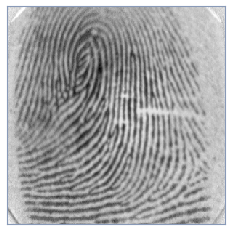

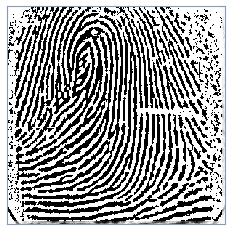

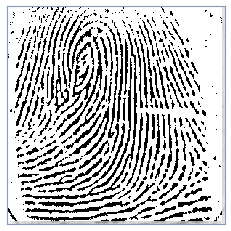

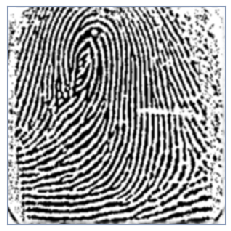

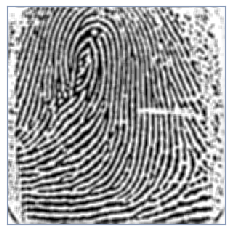

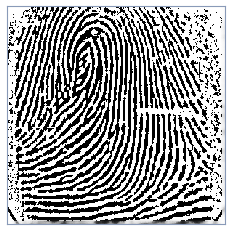

In [23]:
# from medpy.filter.smoothing import anisotropic_diffusion

raw_img_he = histogram_equalisation(raw_img)
raw_img_he_bin = binarise(raw_img_he)
# raw_img_ad = anisotropic_diffusion(raw_img_he_bin)

display_image(raw_img)
display_image(raw_img_he_bin)
display_image(binarise(raw_img))
display_image(blur(raw_img_he_bin))
display_image(filter_averaging(raw_img_he_bin))
display_image(filter_bilateral(raw_img_he_bin))

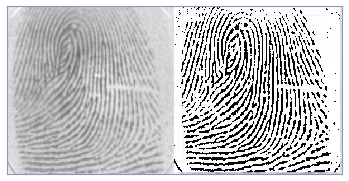

In [24]:
from skimage import exposure

img_bin = binarise(raw_img)
img_adapteq = exposure.equalize_adapthist(img_bin, clip_limit=0.03)
display_image(np.hstack((raw_img, img_adapteq * 255)))

# Image Enhancement

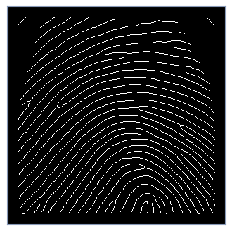

In [25]:
# Revert gray colour levels. Match scale with the raw image for comparison.
path_train = '../data/Fingerprints - Set A/101_1.tif'
path_test = '../data/Fingerprints - Set B/101_1.tif'

# Image loading
img_train = load_image(path_train, True)
img_test = load_image(path_test, True)
# img = histogram_equalisation(img)

img_enhanced_train = enhance_image(img_train, padding=5)
img_enhanced_test = enhance_image(img_test, padding=5)

display_image(img_enhanced_train)

# Minutiae extraction

In [26]:
# Minutiae libs
from scipy.spatial import distance
from itertools import combinations

from libs.minutiae import *

INFO: Plotting terminations' coordinates
INFO: Plotting terminations' coordinates


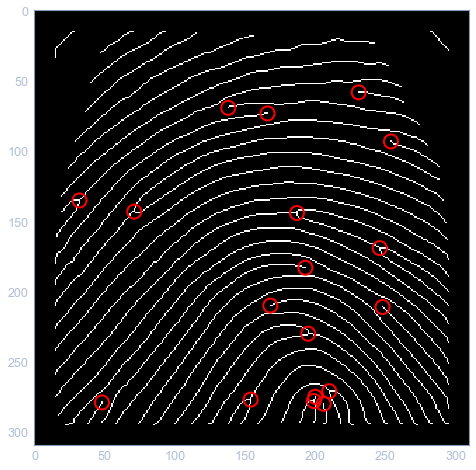

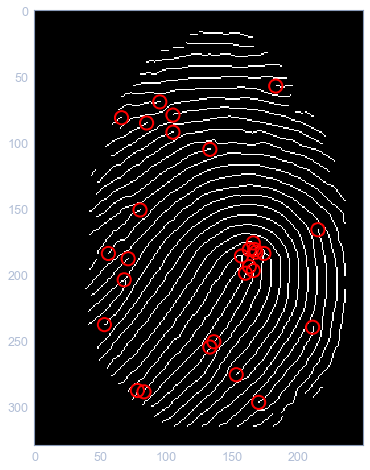

In [27]:
minutiae_base = process_minutiae(img_enhanced_train)
plot_minutiae(img_enhanced_train, minutiae_base, size=8)

minutiae_test = process_minutiae(img_enhanced_test)
plot_minutiae(img_enhanced_test, minutiae_test, size=8)

# Corner Detection - Harris 

In [28]:
# Edges - Harris - matching libs
import cv2
import matplotlib.pyplot as plt

from libs.edges import *

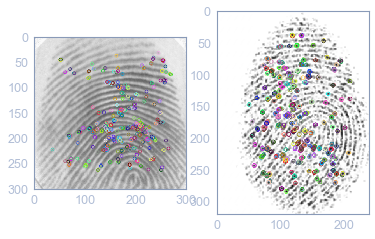

In [29]:
img1 = cv2.imread(path_train, 0)
img2 = cv2.imread(path_test, 0)

edges1, desc1 = edge_processing(img1, threshold=155) 
edges2, desc2 = edge_processing(img2, threshold=155)

plot_edges(img1, img2, edges1, edges2)

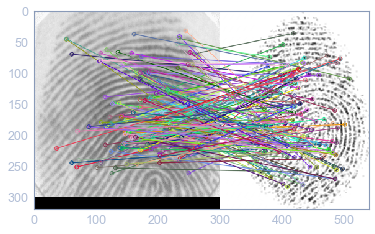

In [30]:
matches = match_edge_descriptors(desc1, desc2)

plot_matches(img1, img2, edges1, edges2, matches)

# Matching

1) Minutiae-based matching - fingerprint alignment and similarity identification. 
One approach is to create a rotation and translation invariant dataset with the minutiae.
Ridges and valleys
Ridges have to be visible and thus the size of the samples must be large. 
http://pubs.sciepub.com/jcsa/1/4/1/

2) Triangular matching and DTW. Copes with deformations in fingerprints. 

3) Query vs template fingerprint matching based on LSE of the euclidian distances between 
points in an angle-curvature space. 

4) Linear vector quantiser neural network 

Overall: minutiae, direct and relation distance matching 

1 - ridge endings and bifurcations are stored on a x, y, orientation space (Q - theta). 
    - decision tree classification for areas in the fingerprints. 
A match is identified if the tolerance window is not reached based on formula sd(m'j, mi)

Direct matching - pixel-wise comparison between images. 


Time and memory implications of each model, together with their matching accuracy. 

Common: correlation-based matching, minutiaebased matching and ridge feature-based matching
Based on: http://lup.lub.lu.se/luur/download?func=downloadFile&recordOId=8949667&fileOId=8949687

Sources of noise:
Translation, rotation, partial overlap, skin condition, pressure

Approaches: CNN - handling feature extraction from images instead of manually handling ridges and valleys
CNNs are grid based and are not rotation invariant. Rotated fingerprints are in different grid areas


Problem formulation: Given a set consisting of pairs of fingerprint images, determine for all
elements of the set whether they correspond to similar fingerprints or not.

## BF match

In [31]:
from main import FingerMatch

In [32]:
path = '../data/Fingerprints - Set A'

In [33]:
fm = FingerMatch('bf')
fm.loadData(path)
fm.trainData()
scores = fm.matchFingerprint(img_test, verbose=False)


INFO: Dataset loaded successfully. Duration: 0.06 sec
INFO: Loading model features. Model: bf
INFO: Training completed in 178.18 sec
No match found. Most similar fingerprint is []


In [34]:
fm = FingerMatch('orb')
fm.loadData(path)
fm.trainData()
scores = fm.matchFingerprint(img_test, verbose=False)


INFO: Dataset loaded successfully. Duration: 0.07 sec
INFO: Loading model features. Model: orb
INFO: Training skipped.
INFO: Training completed in 0.0 sec


AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

## Tree-based

In [35]:
fmt = FingerMatch('tree')
fmt.loadData(path)

fmt.trainData()


INFO: Dataset loaded successfully. Duration: 0.08 sec
INFO: Loading model features. Model: tree
INFO: Training completed in 804.87 sec


In [ ]:
img_tree_test = cv2.imread(path_train, 0)

fmt.matchFingerprint(img_tree_test)

## Matching trees

In [ ]:
# from libs.matching import match_tuples

tuple_base = fmt.images[0]
tuple_test = fmt.images[0]

common_points_base, common_points_test = match_tuples(tuple_base.profile, tuple_test.profile)

# Matching minutiae
image_base = swap(tuple_base.image_enhanced)
minutiae_base = list(tuple_base.profile.keys())

image_test = swap(tuple_test.image_enhanced)
minutiae_test = list(tuple_test.profile.keys())

plot_minutiae(image_base, minutiae_base, size=5)
plot_minutiae(image_test, minutiae_test, size=5)

In [ ]:
# Obtains elements sorted from bottom-up and left to right. First element has a lower order.
sorted_common_points_base = sorted(common_points_base, reverse=True, key=lambda x: x[0])
sorted_common_points_test = sorted(common_points_test, reverse=True, key=lambda x: x[0])
# sorted_common_points = sorted(confirmed_common_points, key=lambda x: x[1])

plot_minutiae_tree(image_base, sorted_common_points_base, size=5)
plot_minutiae_tree(image_test, sorted_common_points_test, size=5)

In [ ]:
# Vertices and edges are considered next. 
# Ratio computation: max (BC, AB) / min (BC, AB) [1] where AB, BC are segment lengths. 
# Edges 
# 1) Quadrant direction
# 2) Ratio of own length and previous edge length as per the formula [1]
# 3) Minimum angle between extension of current edge and the previous one. 

# If the edges processed from the base image do not correspond to the edges in test, trim. 

# Check GAR (Genuine Acceptance Rate) and FRR (False Reject Rates)
# Efficiency % given by #TP / #TestSamples
# Can use one image as base image - and test it against the remaining images of the same finger / user. 
# Roll across all finger instances of each person. 
# Check false acceptance rate. 

# C (N) >= (N/2) where C (N) is the number of common points inn both images and N is 
# the Maximum {Number of points in the [base, input] images}. The five instances in the graph 
# represent when C (N) >= (N/2), C (N) >= (N/1.8), C(N) >= (N/1.6), and C (N) >= (N/1.4), 
# C (N) >= (N/1.2)

# The proposed algorithm is able to generate a matching score when it obtains a minimum of 
# (N/2) + 1 common minutiae points between the base and the input image, where N is the 
# maximum of Number of detected minutiae points in either the base or the input image. 
# FNMR (false non-match rate) does not increase considerably since there is no threshold on 
# no. of minutiae that need to be matched.

edges_base = build_edges(sorted_common_points_base)
edges_test = build_edges(sorted_common_points_test)

In [ ]:
# Solve the issue of quadrant location of computed angles and distances. 

# Produce common list points - via matching. Confirmed and unconfirmed. 
# Confirmed points are used to generate a matching score. 

# Confirmed point matching. 
tuple_base = generate_tuple_profile(minutiae_base)
tuple_test = generate_tuple_profile(minutiae_test)

match_tuples(tuple_base, tuple_test)